# Shell APD Learning eXchange DnA Notebook

## Predicting power usage in the eastern United States

In this notebook, we will go through the cycle of a typical data science project, starting with data collection, cleaning, feature engineering and finally predictive modeling. We will also explore the three different categories of machine learning  problems, and how they work. By the end of this exercise notebook you should have a basic understanding of how data science works.

<img src="https://github.com/robmoratore/ShellDnA/blob/master/data/images/next_steps.png?raw=true" width="1200">

## PJM Hourly Energy Consumption Data

PJM is a regional transmission organization in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

We will be using hourly power consumption data from PJM's East grid. This data set ranges from 2002-2018. The data came from PJM's website and are given in megawatts (MW).

## Overview:

#### Day 1

0. [Introduction](#intro)
1. [Import packages](#setup)
2. [Get the data](#data)
3. [Explore the data](#explore)
4. [Split train and test sets](#traintest)
5. [Regression - Predict energy usage](#model)
    - [Linear regression](#linear)
    - [Gradient-boosted trees](#xgbreg)
    
#### Day 2
6. [Engineer new features](#featureengineer)
7. [Clean the dataset](#cleaning)
8. [Retrain your model with new features](#modelnew)
9. [Classification - Predict weekend and weekday](#classification)    
10. [Cluster - Group the data](#clustering)
11. [Next steps](#nextsteps)


<br><br/>


REGRESSION | CLASSIFICATION | CLUSTERING
- | - | -
<img src="https://github.com/robmoratore/ShellDnA/blob/master/data/images/LR.png?raw=true" width="390"> | <img src="https://github.com/robmoratore/ShellDnA/blob/master/data/images/CLASS1.png?raw=true" width="390"> | <img src="https://github.com/robmoratore/ShellDnA/blob/master/data/images/clustering.png?raw=true" width="320">


# 1. Import some python libraries and define functions we'll need <a class="anchor" id="setup"></a>

In [1]:
%%capture

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.dates as mdates
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.cluster import KMeans
import seaborn as sns
import math
from datetime import datetime

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(7,7)) #
    fig.patch.set_facecolor('white')
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    plt.figure(figsize=(10, 10)) 
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

np.set_printoptions(precision=2)
pd.set_option('display.max_columns', None)
plt.style.use('fivethirtyeight')

plt.rcParams.update({'font.size': 22})

# 2. Download the data to our notebook <a class="anchor" id="data"></a>


In [2]:
url = 'https://github.com/robmoratore/ShellDnA/raw/master/data/PJM_Load.csv'
df_full = pd.read_csv(url, sep = ',', date_parser=["date"])
df_full.index = pd.DatetimeIndex(df_full["date"])
df_full = df_full.drop(columns=['date'])
pjme = df_full[['load', 'dayofyear']]

# 3. Explore the data <a class="anchor" id="explore"></a>

### Let's look at the first few rows of the dataset

In [3]:
pjme.head()

,load,dayofyear
date,,
2002-01-01 01:00:00,30393,1
2002-01-01 02:00:00,29265,1
2002-01-01 03:00:00,28357,1
2002-01-01 04:00:00,27899,1
2002-01-01 05:00:00,28057,1


### Plot energy usage over time

[Text(0,0.5,'Energy (MW)'), Text(0.5,0,'Time')]

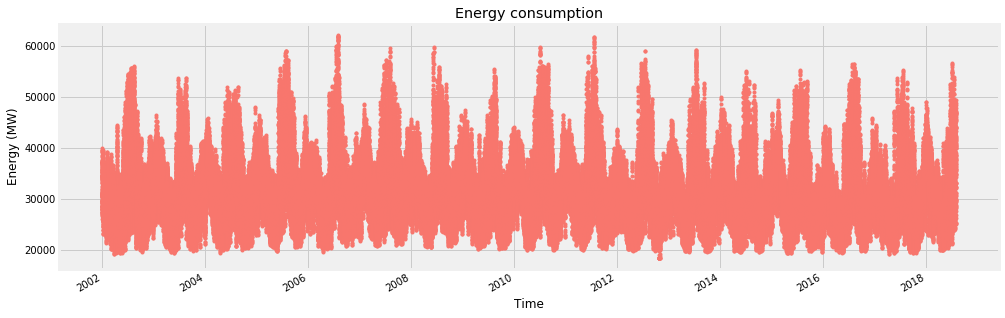

In [4]:
_ = pjme["load"].plot(style='.', figsize=(15,5), color=color_pal[0], title='Energy consumption')
_.set(xlabel="Time", ylabel="Energy (MW)")

# 4. Split the train and testing sets <a class="anchor" id="traintest"></a>

We do that to ensure our model is able to generalize. That means, perform well on unseen data. If we train and test using the same data, the model will memorize that specific output and not learn it.

We will use the data from 2015 on as our test set.

![alt](https://github.com/robmoratore/ShellDnA/blob/master/data/images/train_test.png?raw=true)

<img src="https://github.com/robmoratore/ShellDnA/blob/master/data/images/bias.png?raw=true" />

In [5]:
split_date = '2015-01-01'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

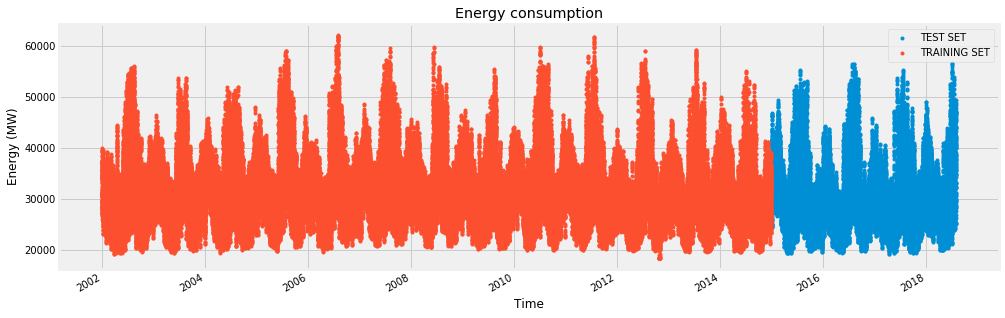

In [6]:
ax = pd.DataFrame(pjme_test["load"]) \
    .rename(columns={'load': 'TEST SET'}) \
    .join(pd.DataFrame(pjme_train["load"]).rename(columns={'load': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Energy consumption', style='.')
_ = ax.set(xlabel="Time", ylabel="Energy (MW)")

# 5. Regression - Can we predict energy use for a given hour? <a class="anchor" id="model"></a>

## 5.1 Start with a simple model - Linear Regression <a class="anchor" id="linear"></a>

[Text(0,0.5,'Energy (MW)'), Text(0.5,0,'Time')]

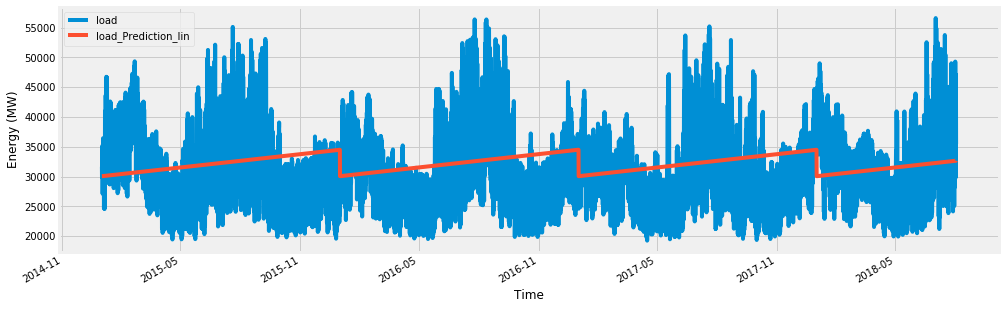

In [7]:
lin_reg = LinearRegression()
lin_reg.fit(pjme_train["dayofyear"].values.reshape(-1, 1), pjme_train["load"].values.reshape(-1, 1))
pjme_test['load_Prediction_lin'] = lin_reg.predict(pjme_test["dayofyear"].values.reshape(-1, 1))
_ = pjme_test[['load','load_Prediction_lin']].plot(figsize=(15, 5))
_.set(xlabel="Time", ylabel="Energy (MW)")

### Check how well our model performs
Which error metrics would you choose?

In [8]:
mse = mean_squared_error(y_true=pjme_test['load'], y_pred=pjme_test['load_Prediction_lin'])
print ("The Mean Squared Error (MSE) is ", round(mse, 2) , "MW\u00b2")
print ("The Root Mean Squared Error (RMSE) is ", round(np.sqrt(mse), 2), "MW")
print ("The Mean Absolute Error (MAE) is ", round(mean_absolute_error(y_true=pjme_test['load'], y_pred=pjme_test['load_Prediction_lin']), 2), "MW")
print ("The Mean Absolute Percentage Error is ", round(mean_absolute_percentage_error(y_true=pjme_test['load'], y_pred=pjme_test['load_Prediction_lin']), 2), "%")
print ("The R\u00b2 (coefficient of determination) regression score is ", round(r2_score(y_true=pjme_test['load'],y_pred=pjme_test['load_Prediction_lin']), 2))

The Mean Squared Error (MSE) is  45027693.2 MW²
The Root Mean Squared Error (RMSE) is  6710.27 MW
The Mean Absolute Error (MAE) is  5444.21 MW
The Mean Absolute Percentage Error is  18.19 %
The R² (coefficient of determination) regression score is  -0.08


## 5.2 Get fancy with some Machine Learning - Gradient-boosted trees <a class="anchor" id="xgbreg"></a>

This is one of the cleverest ways of combining multiple decision trees. Here, instead of having one single tree responsible for all the decisions, you use many trees on sequence. That means, the next tree does not try to predict the final result but the error of the previous tree. When you add all trees together, the results are generally very good

<img src="https://github.com/robmoratore/ShellDnA/blob/master/data/images/xgb_reg.png?raw=true" width="600">
<img src="https://github.com/robmoratore/ShellDnA/blob/master/data/images/xgb2.png?raw=true" width="800">

#### Can you think of other ways of using multiple decision trees to make predictions?

[Text(0,0.5,'Energy (MW)'), Text(0.5,0,'Time')]

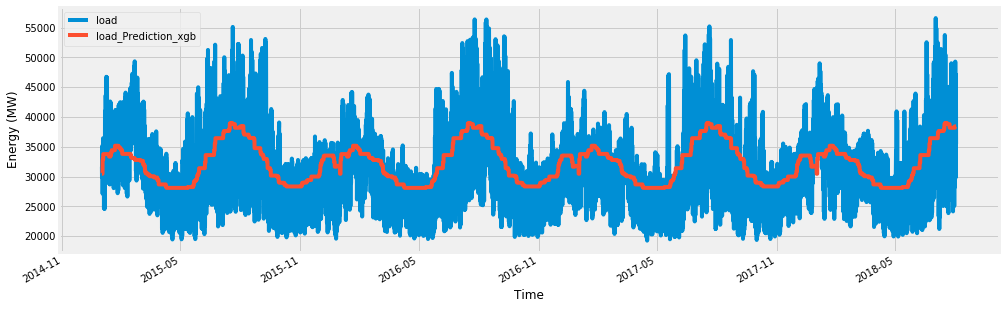

In [9]:
include_variables = "dayofyear"
reg = xgb.XGBRegressor(n_estimators=50)
reg.fit(pjme_train[include_variables].values.reshape(-1, 1), pjme_train["load"].values.reshape(-1, 1))
pjme_test['load_Prediction_xgb'] = reg.predict(pjme_test[include_variables].values.reshape(-1, 1))
_ = pjme_test[['load','load_Prediction_xgb']].plot(figsize=(15, 5))
_.set(xlabel="Time", ylabel="Energy (MW)")

### Check how well our model performs

In [10]:
mse = mean_squared_error(y_true=pjme_test['load'], y_pred=pjme_test['load_Prediction_xgb'])
print ("The Mean Squared Error (MSE) is ", round(mse, 2), "MW\u00b2")
print ("The Root Mean Squared Error (RMSE) is ", round(np.sqrt(mse), 2), "MW")
print ("The Mean Absolute Error (MAE) is ", round(mean_absolute_error(y_true=pjme_test['load'], y_pred=pjme_test['load_Prediction_xgb']), 2), "MW")
print ("The Mean Absolute Percentage Error is ", round(mean_absolute_percentage_error(y_true=pjme_test['load'], y_pred=pjme_test['load_Prediction_xgb']), 2), "%")
print ("The R\u00b2 (coefficient of determination) regression score is ", round(r2_score(y_true=pjme_test['load'],y_pred=pjme_test['load_Prediction_xgb']), 2))

The Mean Squared Error (MSE) is  31031470.06 MW²
The Root Mean Squared Error (RMSE) is  5570.59 MW
The Mean Absolute Error (MAE) is  4354.54 MW
The Mean Absolute Percentage Error is  14.6 %
The R² (coefficient of determination) regression score is  0.25


# 6. Engineer New Features <a class="anchor" id="featureengineer"></a>

<img src="https://github.com/robmoratore/ShellDnA/blob/master/data/images/pipeline.png?raw=true" width="1200">


Here, we can create features to distinguish a seashell image from the Shell's logo. For example, we can have a feature "red" that represents the amount of red pixels present in the picture (in %, for example). That feature, will help the machine learning model to distinguish between the two images. Another example is the image's symmetry (yes/no).


<img src="https://github.com/robmoratore/ShellDnA/blob/master/data/images/shell.png?raw=true" width="700">

<br/><br/>

### Which features would you create to help predict load?

In [11]:
 pjme.head()

,load,dayofyear
date,,
2002-01-01 01:00:00,30393,1
2002-01-01 02:00:00,29265,1
2002-01-01 03:00:00,28357,1
2002-01-01 04:00:00,27899,1
2002-01-01 05:00:00,28057,1


<br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/>

### We created some features ahead of time for you 

In [12]:
df_full.head().round(2)

,load,loadmean_prevweek,load_peak,year,quarter,month,weekofyear,dayofyear,dayofmonth,dayofweek,hour,daytime,weekend,holiday,businessday,season,temp,precipitation
date,,,,,,,,,,,,,,,,,,
2002-01-01 01:00:00,30393,NaN,29532.03,2002,1,1,1,1,1,3,1,0,0,1,0,1,-6.0,0.0
2002-01-01 02:00:00,29265,NaN,31528.57,2002,1,1,1,1,1,3,2,0,0,1,0,1,-6.0,0.0
2002-01-01 03:00:00,28357,NaN,30242.43,2002,1,1,1,1,1,3,3,0,0,1,0,1,-6.0,0.0
2002-01-01 04:00:00,27899,NaN,29388.26,2002,1,1,1,1,1,3,4,0,0,1,0,1,-6.0,0.0
2002-01-01 05:00:00,28057,NaN,31163.64,2002,1,1,1,1,1,3,5,0,0,1,0,1,-6.0,0.0


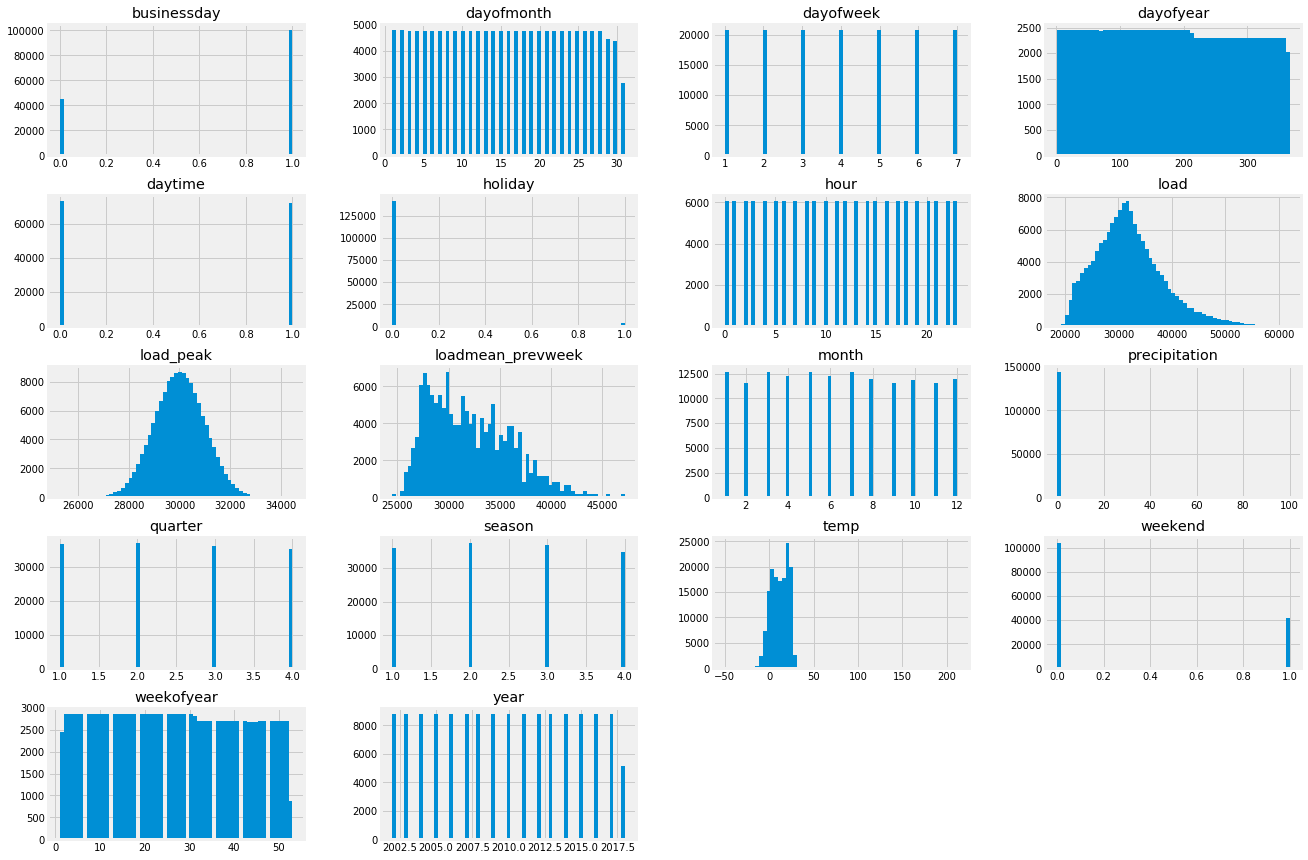

In [13]:
_ = df_full.hist(bins=61, figsize=(20,15))

# 7. Clean the dataset <a class="anchor" id="cleaning"></a>

### Outliers

[Text(0,0.5,'Temperature (C)'), Text(0.5,0,'Time')]

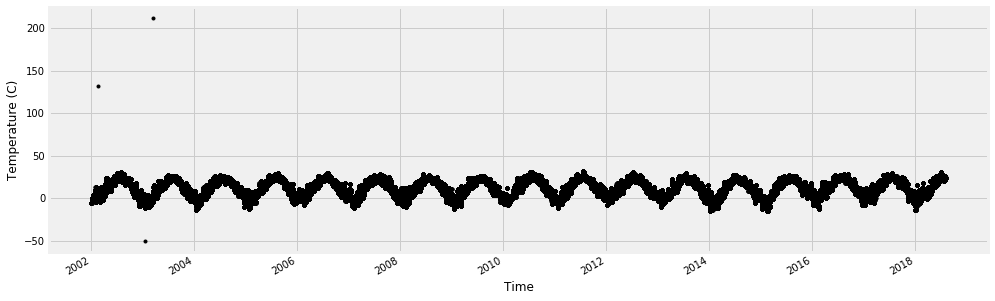

In [14]:
_ = df_full["temp"].plot(style='k.', figsize=(15,5))
_.set(xlabel="Time", ylabel="Temperature (C)")

[Text(0,0.5,'Temperature (C)'), Text(0.5,0,'Time')]

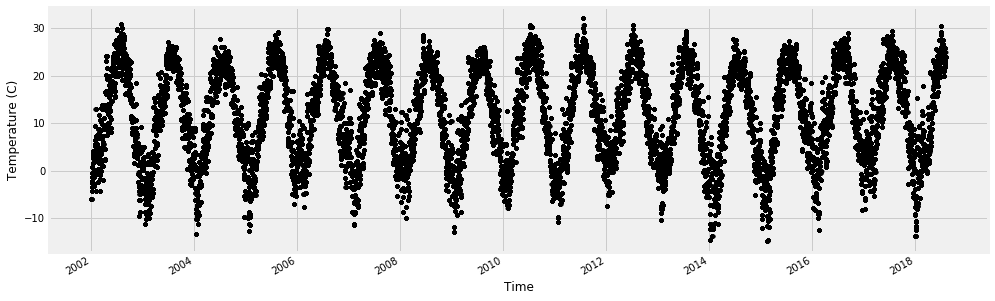

In [15]:
df_full = df_full[(df_full['temp']>=-25) & (df_full['temp']<=50)]
_ = df_full["temp"].plot(style='k.', figsize=(15,5))
_.set(xlabel="Time", ylabel="Temperature (C)")

### Missing values

In [16]:
len(df_full.index)-df_full.count()

load                   0
loadmean_prevweek    287
load_peak              0
year                   0
quarter                0
month                  0
weekofyear             0
dayofyear              0
dayofmonth             0
dayofweek              0
hour                   0
daytime                0
weekend                0
holiday                0
businessday            0
season                 0
temp                   0
precipitation          6
dtype: int64

In [17]:
df_full = df_full.dropna()
len(df_full.index)-df_full.count()

load                 0
loadmean_prevweek    0
load_peak            0
year                 0
quarter              0
month                0
weekofyear           0
dayofyear            0
dayofmonth           0
dayofweek            0
hour                 0
daytime              0
weekend              0
holiday              0
businessday          0
season               0
temp                 0
precipitation        0
dtype: int64

# 8. Retrain Gradient-boosted trees model with new features <a class="anchor" id="modelnew"></a>

We can now retrain the Gradient-boosted trees model using the new features to see if performance improves.

Here is a list of available features that can be used in the model.

In [18]:
df_full.drop(columns=['load']).columns

Index(['loadmean_prevweek', 'load_peak', 'year', 'quarter', 'month',
       'weekofyear', 'dayofyear', 'dayofmonth', 'dayofweek', 'hour', 'daytime',
       'weekend', 'holiday', 'businessday', 'season', 'temp', 'precipitation'],
      dtype='object')

Select which features you would like to include in the model, and add them to the `include_variables` list bellow.
Then check how the model performs.

[Text(0,0.5,'Energy (MW)'), Text(0.5,0,'Time')]

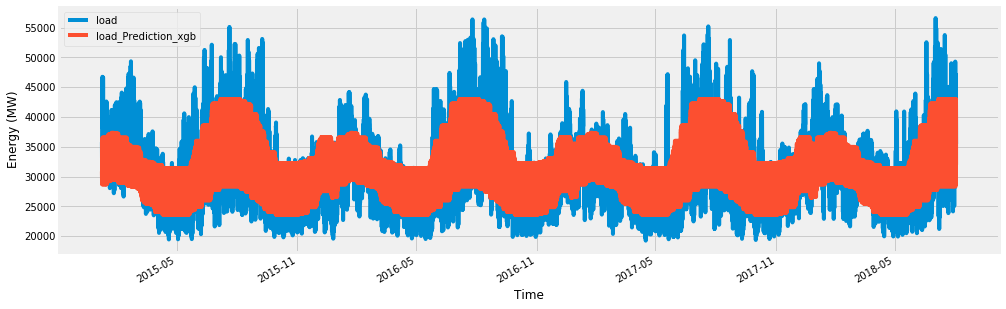

In [19]:
# SELECT A COMBINATION OF FEATURES HERE
include_variables = ['hour', 'dayofyear', 'quarter']
#

split_date = '2015-01-01'
df_full_train = df_full.loc[df_full.index <= split_date].copy()
df_full_test = df_full.loc[df_full.index > split_date].copy()

df_full_test.index = pd.DatetimeIndex(df_full_test.index)
df_full_train.index = pd.DatetimeIndex(df_full_train.index)

reg = xgb.XGBRegressor(n_estimators=50)
reg.fit(df_full_train[include_variables], df_full_train["load"].values.reshape(-1, 1))
df_full_test['load_Prediction_xgb'] = reg.predict(df_full_test[include_variables])
_ = df_full_test[['load','load_Prediction_xgb']].plot(figsize=(15, 5))
_.set(xlabel="Time", ylabel="Energy (MW)")

### Check how well our model performs
Which Feature gives you the lowest MAE and highest R$^{2}$?

In [20]:
mse = mean_squared_error(y_true=df_full_test['load'], y_pred=df_full_test['load_Prediction_xgb'])
print ("The Mean Squared Error (MSE) is ", round(mse, 2), "MW\u00b2")
print ("The Root Mean Squared Error (RMSE) is ", round(np.sqrt(mse), 2), "MW")
print ("The Mean Absolute Error (MAE) is ", round(mean_absolute_error(y_true=df_full_test['load'], y_pred=df_full_test['load_Prediction_xgb']), 2), "MW")
print ("The Mean Absolute Percentage Error is ", round(mean_absolute_percentage_error(y_true=df_full_test['load'], y_pred=df_full_test['load_Prediction_xgb']), 2), "%")
print ("The R\u00b2 (coefficient of determination) regression score is ", round(r2_score(y_true=df_full_test['load'],y_pred=df_full_test['load_Prediction_xgb']), 2))

The Mean Squared Error (MSE) is  16502377.28 MW²
The Root Mean Squared Error (RMSE) is  4062.31 MW
The Mean Absolute Error (MAE) is  3209.28 MW
The Mean Absolute Percentage Error is  10.45 %
The R² (coefficient of determination) regression score is  0.6


### Feature Importances
Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.

We can see that the day of year was most commonly used to split trees, while hour came in next. Quarter has low importance (never used in any splits even) due to the fact that it could be created by different dayofyear splits.

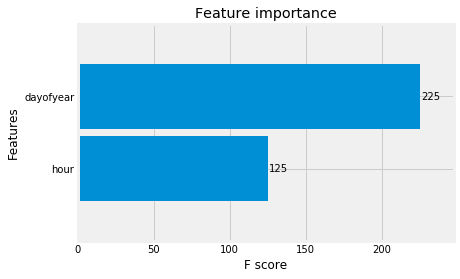

In [21]:
_ = plot_importance(reg, height=0.9)

## 8.1 Look at Worst and Best Predicted Days <a class="anchor" id="bestworst"></a>

In [22]:
df_full_test['error'] = df_full_test['load'] - df_full_test['load_Prediction_xgb']
df_full_test['abs_error'] = df_full_test['error'].apply(np.abs)
error_by_day = df_full_test.groupby(['year','month','dayofmonth']) \
    .mean()[['load','load_Prediction_xgb','error','abs_error']]

### Worst days

In [23]:
error_by_day.sort_values('abs_error', ascending=False).round(2).head(10)

load  load_Prediction_xgb         error  \
year month dayofmonth                                                
2015 2     20          44694.04         32909.570312  11784.469727   
2016 9     9           43836.96         32927.238281  10909.719727   
2015 2     16          43949.50         33115.718750  10833.780273   
2018 1     5           44197.79         33584.199219  10613.589844   
           6           43565.75         33584.199219   9981.549805   
2017 9     2           24201.46         34055.039062  -9853.580078   
2015 6     28          26893.25         36582.429688  -9689.179688   
2016 7     3           26926.12         36582.429688  -9656.299805   
2017 5     19          38032.58         28492.810547   9539.780273   
     8     6           27709.88         37082.160156  -9372.290039   

                          abs_error  
year month dayofmonth                
2015 2     20          11784.469727  
2016 9     9           10909.719727  
2015 2     16          10833.780273  
2018 1     5           10613.589844  
           6            9981.549805  
2017 9     2            9853.580078  
2015 6     28           9689.179688  
2016 7     3            9656.299805  
2017 5     19           9539.780273  
     8     6            9372.290039

[Text(0,0.5,'Energy (MW)'), Text(0.5,0,'Time')]

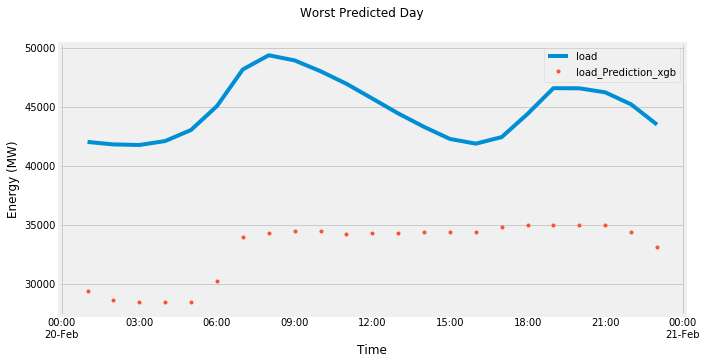

In [24]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)

_ = df_full_test[['load','load_Prediction_xgb']][(df_full_test[['load','load_Prediction_xgb']].index>'2015-02-20') & (df_full_test[['load','load_Prediction_xgb']].index<'2015-02-21')].plot(ax=ax, style=['-','.'])
plot = plt.suptitle('Worst Predicted Day')
_.set(xlabel="Time", ylabel="Energy (MW)")

Temperature in worst predicted day

In [25]:
df_full[df_full.index=='2015-02-20 00:00:00']['temp'].head()

date
2015-02-20   -14.555556
Name: temp, dtype: float64

<img src="https://github.com/robmoratore/ShellDnA/blob/master/data/images/cold.png?raw=true" width="1000">

### Best days

In [26]:
error_by_day.sort_values('abs_error', ascending=True).round(2).head(10)

load  load_Prediction_xgb       error   abs_error
year month dayofmonth                                                       
2017 5     2           28546.92         28492.810547   54.110001  491.329987
2018 5     17          28035.21         28492.810547 -457.600006  564.130005
2017 12    9           32562.62         32892.921875 -330.299988  571.729980
     10    24          28657.42         29055.419922 -398.000000  580.690002
2018 5     31          31445.00         31767.939453 -322.940002  650.270020
2015 10    28          28500.96         29055.419922 -554.460022  736.179993
2018 5     22          28450.00         29179.919922 -729.909973  766.289978
2016 10    27          28611.17         29055.419922 -444.250000  772.169983
     4     9           28517.75         28492.810547   24.940001  773.309998
2018 5     11          27865.33         28492.810547 -627.469971  792.049988

[Text(0,0.5,'Energy (MW)'), Text(0.5,0,'Time')]

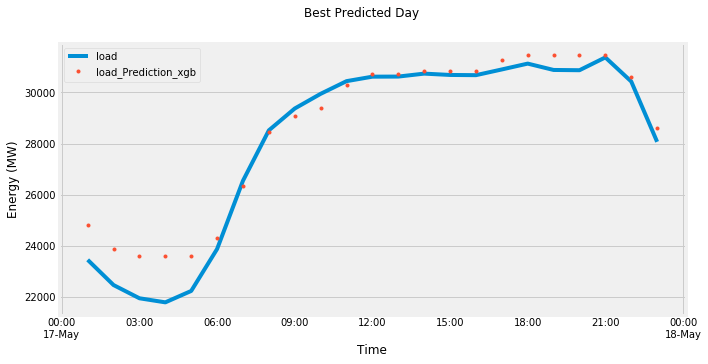

In [27]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = df_full_test[['load','load_Prediction_xgb']][(df_full_test[['load','load_Prediction_xgb']].index>'2018-05-17') & (df_full_test[['load','load_Prediction_xgb']].index<'2018-05-18')].plot(ax=ax, style=['-','.'])
plot = plt.suptitle('Best Predicted Day')
_.set(xlabel="Time", ylabel="Energy (MW)")

# 9. Classification - Can we predict if a day is a weekend or a weekday? <a class="anchor" id="classification"></a>

<img src="https://github.com/robmoratore/ShellDnA/blob/master/data/images/xgb_class.png?raw=true" width="900"> 

In [28]:
df_day = df_full.groupby(['year','month','dayofmonth']).sum()[['load']] \
.join(df_full.groupby(['year','month','dayofmonth']).max()[['temp', 'weekend']], how='inner')
df_day.reset_index(inplace=True)
df_day['date'] = df_day['year'].astype(str) + '-' + df_day['month'].astype(str) + '-' + df_day['dayofmonth'].astype(str)
df_day['date'] = df_day['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df_day.index = df_day['date']
df_day = df_day.drop(['year','month','dayofmonth', 'date'], axis=1)
df_day = df_day[df_day['load']>=500000] #remove end of year outliers which don't have 24 hours of data to sum

df_day.head(14)

,load,temp,weekend
date,,,
2002-01-07,800012,0.777778,0
2002-01-08,824710,-2.555556,0
2002-01-09,810628,-0.722222,0
2002-01-10,755317,3.555556,0
2002-01-11,742741,4.222222,0
2002-01-12,683205,3.277778,1
2002-01-13,673268,2.666667,1
2002-01-14,758471,1.500000,0
2002-01-15,749371,3.944444,0


<img src="https://github.com/robmoratore/ShellDnA/blob/master/data/images/confusion_matrix2.png?raw=true" width="500">

\begin{align}
Precision = \frac{TP}{TP+FP} 
\end{align}

<img src="https://github.com/robmoratore/ShellDnA/blob/master/data/images/confusion_matrix_precision.png?raw=true" width="500">

\begin{align}
Recall = \frac{TP}{TP+FN} 
\end{align}

In [29]:
df_day_train = df_day.loc[df_day.index < '2015-01-01'].copy()
df_day_test = df_day.loc[df_day.index >= '2015-01-01'].copy()

X_train = df_day_train[['load', 'temp']]
y_train = df_day_train["weekend"]
X_test = df_day_test[['load', 'temp']]
y_test = df_day_test["weekend"]

In [30]:
%%capture
clas = xgb.XGBClassifier(n_estimators=50)
clas.fit(X_train, y_train)
df_day_test['weekend_pred'] = clas.predict(X_test)

Confusion matrix, without normalization
[[737 195]
 [ 73 299]]


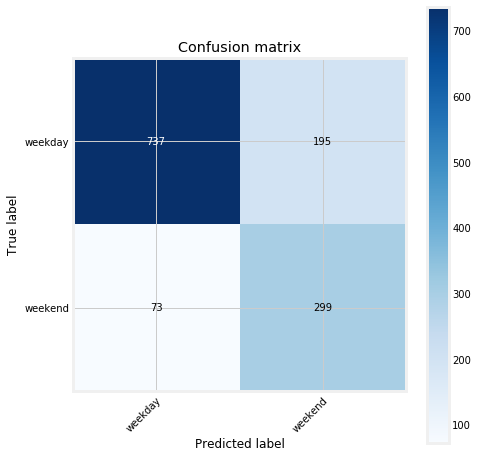

<Figure size 720x720 with 0 Axes>

In [31]:
plot_confusion_matrix(df_day_test['weekend'], df_day_test['weekend_pred'], classes=['weekday', 'weekend'], normalize=False,
                      title='Confusion matrix')

<img src="https://github.com/robmoratore/ShellDnA/blob/master/data/images/confusion_matrix.png?raw=true" width="500" align="left">

### Calculate precision and recall

In [32]:
print ("The Precision is ", round(precision_score(y_true=y_test, y_pred=df_day_test['weekend_pred']), 2))
print ("The Recall is ", round(recall_score(y_true=y_test, y_pred=df_day_test['weekend_pred']), 2))

The Precision is  0.61
The Recall is  0.8


### Feature Importances

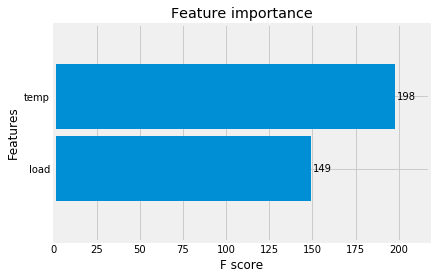

In [33]:
_ = plot_importance(clas, height=0.9)

# 10. K-Means clustering - What are some innate groups in the data? <a class="anchor" id="clustering"></a>

K-means clustering is a classification algorithm used to automatically divide a large group into smaller groups.

The name comes because you choose K groups to split our data into. You take the average of these groups to improve the accuracy of the group. The cluster is just another name for a group, because different groups are said to 'cluster' together.

<img src="https://raw.githubusercontent.com/robmoratore/ShellDnA/master/data/images/k_means.gif" width="400">

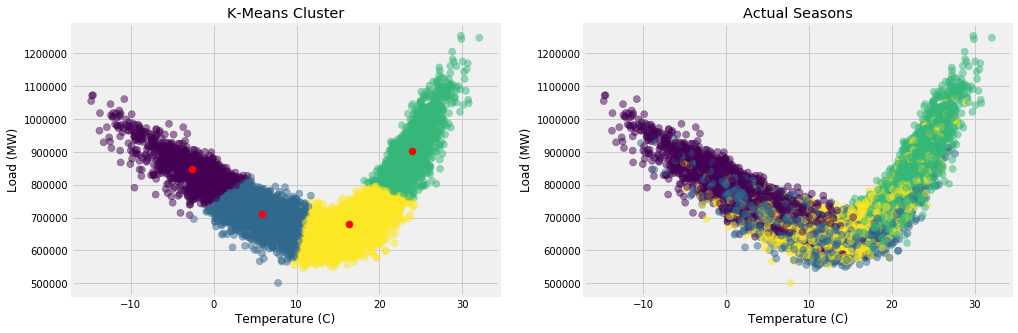

In [34]:
df_kmeans = df_full.groupby(['year','month','dayofmonth', 'season']).sum()[['load']] \
.join(df_full.groupby(['year','month','dayofmonth', 'season']).max()[['temp']], how='inner')
df_kmeans = df_kmeans[df_kmeans['load']>=500000] #remove end of year outliers which don't have 24 hours of data to sum
df_kmeans.reset_index(inplace=True)
df_kmeans_plot = df_kmeans
df_kmeans=(df_kmeans-df_kmeans.min())/(df_kmeans.max()-df_kmeans.min())

kmeans = KMeans(n_clusters=4).fit(df_kmeans[['temp', 'load']])
centroids = kmeans.cluster_centers_
labs = pd.DataFrame({'temp': df_kmeans['temp'],
     'load': df_kmeans['load'],
     'labels': kmeans.labels_.astype(float)
    }).groupby(['labels']).mean().sort_values(by=['temp', 'load']).reset_index()
labs['labels_ordered'] = [0, 1, 3, 2]
labs = pd.DataFrame({'labels': kmeans.labels_.astype(float)
    }).merge(labs, left_on='labels', right_on='labels', how='left')

centroids[:,0] = centroids[:,0] * (df_kmeans_plot['temp'].max() - df_kmeans_plot['temp'].min()) + df_kmeans_plot['temp'].min()
centroids[:,1] = centroids[:,1] * (df_kmeans_plot['load'].max() - df_kmeans_plot['load'].min()) + df_kmeans_plot['load'].min()
        
plt.subplots(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(df_kmeans_plot['temp'], df_kmeans_plot['load'], c=labs['labels_ordered'], s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.xlabel('Temperature (C)')
plt.ylabel('Load (MW)')
plt.title('K-Means Cluster')

plt.subplot(1, 2, 2)
plt.scatter(df_kmeans_plot['temp'], df_kmeans_plot['load'], c=df_kmeans['season'], s=50, alpha=0.5)
plt.xlabel('Temperature (C)')
plt.ylabel('Load (MW)')
_ = plt.title('Actual Seasons')

# 11. What are the next steps? <a class="anchor" id="nextsteps"></a>

<img src="https://github.com/robmoratore/ShellDnA/blob/master/data/images/next_steps.png?raw=true" width="1200">